# Rossmann Sales

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

Based on the following video [tutorial](https://www.youtube.com/watch?time_continue=127&v=1-NYPQw5THU).

In [117]:
import os
import pickle
import operator
import numpy as np
import pandas as pd
import datetime as dt
from glob import glob
from isoweek import Week
import matplotlib.pyplot as plt
from IPython.display import HTML
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler

import keras
import keras.backend as K
from keras.models import Model
from keras.layers import (
    Input, Dense, Flatten, Embedding, Dropout, merge, concatenate
)

## Data

In [2]:
tables = {
    os.path.splitext(os.path.basename(file))[0]: pd.read_csv(file, low_memory=False) 
    for file in glob('data/*.csv')
}  

In [3]:
print('Tables: \n\n%s' % '\n'.join(tables.keys()))

Tables: 

state_names
googletrend
test
weather
train
store_states
store
sample_submission


In [4]:
training, test = tables['train'], tables['test']

print('Training dataset size: %d' % len(training))
print('Test dataset size: %d' % len(test))

Training dataset size: 1017209
Test dataset size: 41088


### Preprocessing 

In [5]:
training['StateHoliday'] = training['StateHoliday'] != '0'
test['StateHoliday'] = test['StateHoliday'] != '0'

In [6]:
def join(
    left: pd.DataFrame, 
    right: pd.DataFrame, 
    left_on,
    right_on=None
):
    if right_on is None:
        right_on = left_on
        
    return left.merge(
        right, 
        how='left', 
        left_on=left_on, 
        right_on=right_on,
        suffixes=("", "_y")
    )

In [7]:
weather = join(tables['weather'], tables['state_names'], 'file', 'StateName')

In [8]:
googletrend = tables['googletrend']

googletrend['Date'] = googletrend['week'].apply(
    lambda x: str(x).split(' - ')[0]
)

googletrend['State'] = googletrend['file'].apply(
    lambda x: str(x).split('_')[-1]
)

googletrend.loc[googletrend['State'] == 'NI', 'State'] = 'HB,NI'

In [9]:
def add_datepart(df):
    assert 'Date' in df
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Week'] = df.Date.dt.week
    df['Day'] = df.Date.dt.day

In [10]:
add_datepart(weather)
add_datepart(googletrend)
add_datepart(training)
add_datepart(test)

In [11]:
store, store_states = tables['store'], tables['store_states']

In [12]:
trend_de = googletrend[googletrend['file'] == 'Rossmann_DE']
store = join(store, store_states, 'Store')
joined = join(training, store, 'Store')
joined = join(joined, googletrend, ['State', 'Year', 'Week'])
joined = joined.merge(trend_de, 'left', ['Year', 'Week'], suffixes=('', '_DE'))
joined = join(joined, weather, ['State', 'Date'])

In [13]:
joined_test = test.merge(store, how='left', left_on='Store', right_index=True)
print('No. StoreType nulls in joined_test: %d' % sum(joined_test['StoreType'].isnull()))

No. StoreType nulls in joined_test: 48


In [14]:
joined['CompetitionOpenSinceYear'] = joined['CompetitionOpenSinceYear'].fillna(1900).astype(np.int32)
joined['CompetitionOpenSinceMonth'] = joined['CompetitionOpenSinceMonth'].fillna(1).astype(np.int32)

joined['Promo2SinceYear'] = joined['Promo2SinceYear'].fillna(1900).astype(np.int32)
joined['Promo2SinceWeek'] = joined['Promo2SinceWeek'].fillna(1).astype(np.int32)

In [15]:
joined['CompetitionOpenSince'] = pd.to_datetime(
    joined.apply(
        lambda x: dt.datetime(
            x['CompetitionOpenSinceYear'], x['CompetitionOpenSinceMonth'], 15
        ), axis = 1
    ).astype(pd.datetime)
)

joined['CompetitionDaysOpen'] = joined['Date'].subtract(joined['CompetitionOpenSince']).dt.days

In [16]:
joined.loc[joined['CompetitionDaysOpen'] < 0, 'CompetitionDaysOpen'] = 0
joined.loc[joined['CompetitionOpenSinceYear'] < 1990, 'CompetitionDaysOpen'] = 0

In [17]:
joined['CompetitionMonthsOpen'] = joined['CompetitionDaysOpen'] // 30
joined.loc[joined['CompetitionMonthsOpen'] > 24, 'CompetitionMonthsOpen'] = 24

In [18]:
joined['Promo2Since'] = pd.to_datetime(
    joined.apply(
        lambda x: Week(
            x['Promo2SinceYear'], x['Promo2SinceWeek']
        ).monday(), axis=1
    ).astype(pd.datetime)
)

joined['Promo2Days'] = joined['Date'].subtract(joined['Promo2Since']).dt.days

In [19]:
joined.loc[joined['Promo2Days'] < 0, 'Promo2Days'] = 0
joined.loc[joined['Promo2SinceYear'] < 1990, 'Promo2Days'] = 0

In [20]:
joined['Promo2Weeks'] = joined['Promo2Days'] // 7
joined.loc[joined['Promo2Weeks'] < 0, 'Promo2Weeks'] = 0
joined.loc[joined['Promo2Weeks'] > 25, 'Promo2Weeks'] = 25

### Durations

In [25]:
columns = ['Date', 'Store', 'Promo', 'StateHoliday', 'SchoolHoliday']

In [26]:
class Elapsed():
    '''
        For estimating durations between different events.
    '''
    
    def __init__(self, field):
        self.field = field
        self.last = pd.to_datetime(np.nan)
        self.last_store = 0
        
    def get(self, row):
        if row['Store'] != self.last_store:
            self.last = pd.to_datetime(np.nan)
            self.last_store = row.Store
            
        if row[self.field]:
            self.last = row['Date']
            
        return row['Date'] - self.last

In [27]:
df = training[columns]

In [28]:
def add_elapsed(field, prefix):
    sh_el = Elapsed(field)
    df[prefix+field] = df.apply(sh_el.get, axis=1)

In [29]:
df = df.sort_values(['Store', 'Date'])
add_elapsed('SchoolHoliday', 'After')

df = df.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed('SchoolHoliday', 'Before')

df = df.sort_values(['Store', 'Date'])
add_elapsed('StateHoliday', 'After')

df = df.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed('StateHoliday', 'Before')

df = df.sort_values(['Store', 'Date'])
add_elapsed('Promo', 'After')

df = df.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed('Promo', 'Before')

df = df.set_index('Date')

In [30]:
columns =['SchoolHoliday', 'StateHoliday', 'Promo']

In [31]:
for o in ['Before', 'After']:
    for p in columns:
        a = o + p
        df[a] = df[a].fillna(pd.Timedelta(0)).dt.days

In [32]:
# No. holidays in a week before
bwd = df[['Store'] + columns].sort_index().groupby('Store').rolling(7, min_periods=1).sum()

# No. holidays in a week after
fwd = df[['Store'] + columns].sort_index(
    ascending=False
).groupby('Store').rolling(7, min_periods=1).sum()

In [33]:
bwd.drop('Store', 1, inplace=True)
bwd.reset_index(inplace=True)

fwd.drop('Store', 1, inplace=True)
fwd.reset_index(inplace=True)

df.reset_index(inplace=True)

In [34]:
df = df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df = df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

df.drop(columns, 1, inplace=True)

In [35]:
df.head()

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,2015-07-31,1,0,0,57,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
1,2015-07-30,1,0,0,56,0,0,0,4.0,0.0,4.0,2.0,0.0,2.0
2,2015-07-29,1,0,0,55,0,0,0,3.0,0.0,3.0,3.0,0.0,3.0
3,2015-07-28,1,0,0,54,0,0,0,2.0,0.0,2.0,4.0,0.0,4.0
4,2015-07-27,1,0,0,53,0,0,0,1.0,0.0,1.0,5.0,0.0,5.0


In [36]:
df.to_csv('processed_data/df.csv')

In [41]:
df = pd.read_csv('processed_data/df.csv', index_col=0)
df['Date'] = pd.to_datetime(df['Date'])

/Users/karolis/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:466: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [44]:
joined = join(joined, df, ['Store', 'Date'])

In [45]:
joined.to_csv('processed_data/joined.csv')

In [46]:
joined = pd.read_csv('processed_data/joined.csv', index_col=0)
joined['Date'] = pd.to_datetime(joined['Date'])

/Users/karolis/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:466: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [47]:
print('Features: \n\n%s' % '\n'.join(joined.columns))

Features: 

Store
DayOfWeek
Date
Sales
Customers
Open
Promo
StateHoliday
SchoolHoliday
Year
Month
Week
Day
StoreType
Assortment
CompetitionDistance
CompetitionOpenSinceMonth
CompetitionOpenSinceYear
Promo2
Promo2SinceWeek
Promo2SinceYear
PromoInterval
State
file
week
trend
Date_y
Month_y
Day_y
file_DE
week_DE
trend_DE
Date_DE
State_DE
Month_DE
Day_DE
file_y
Max_TemperatureC
Mean_TemperatureC
Min_TemperatureC
Dew_PointC
MeanDew_PointC
Min_DewpointC
Max_Humidity
Mean_Humidity
Min_Humidity
Max_Sea_Level_PressurehPa
Mean_Sea_Level_PressurehPa
Min_Sea_Level_PressurehPa
Max_VisibilityKm
Mean_VisibilityKm
Min_VisibilitykM
Max_Wind_SpeedKm_h
Mean_Wind_SpeedKm_h
Max_Gust_SpeedKm_h
Precipitationmm
CloudCover
Events
WindDirDegrees
StateName
Year_y
Month_y.1
Week_y
Day_y.1
CompetitionOpenSince
CompetitionDaysOpen
CompetitionMonthsOpen
Promo2Since
Promo2Days
Promo2Weeks
AfterSchoolHoliday
BeforeSchoolHoliday
AfterStateHoliday
BeforeStateHoliday
AfterPromo
BeforePromo
SchoolHoliday_bw
StateHoliday_b

### Creating Entity Embeddings

In [48]:
# Embedding Dimensionality
cat_var_dict = {
    'Store': 50,
    'DayOfWeek': 6,
    'Year': 2,
    'Month': 6,
    'Day': 10,
    'StateHoliday': 3,
    'CompetitionMonthsOpen': 2,
    'Promo2Weeks': 1,
    'StoreType': 2,
    'Assortment': 3,
    'PromoInterval': 3,
    'CompetitionOpenSinceYear': 4,
    'Promo2SinceYear': 4,
    'State': 6,
    'Week': 2,
    'Events': 4,
    'Promo_fw': 1,
    'Promo_bw': 1,
    'StateHoliday_fw': 1,
    'StateHoliday_bw': 1,
    'SchoolHoliday_fw': 1,
    'SchoolHoliday_bw': 1
}

In [50]:
cat_vars = [
    o[0] for o in sorted(
        cat_var_dict.items(), key=operator.itemgetter(1), reverse=True
    )
]

In [51]:
cat_vars

['Store',
 'Day',
 'DayOfWeek',
 'Month',
 'State',
 'CompetitionOpenSinceYear',
 'Promo2SinceYear',
 'Events',
 'StateHoliday',
 'Assortment',
 'PromoInterval',
 'Year',
 'CompetitionMonthsOpen',
 'StoreType',
 'Week',
 'Promo2Weeks',
 'Promo_fw',
 'Promo_bw',
 'StateHoliday_fw',
 'StateHoliday_bw',
 'SchoolHoliday_fw',
 'SchoolHoliday_bw']

In [64]:
contin_vars = [
    'CompetitionDistance',
    'Max_TemperatureC',
    'Mean_TemperatureC',
    'Min_TemperatureC',
    'Max_Humidity',
    'Mean_Humidity',
    'Min_Humidity',
    'Max_Wind_SpeedKm_h',
    'Mean_Wind_SpeedKm_h',
    'CloudCover',
    'trend',
    'trend_DE',
    'AfterStateHoliday',
    'BeforeStateHoliday',
    'Promo',
    'SchoolHoliday'
]

In [65]:
for v in contin_vars:
    joined.loc[joined[v].isnull(), v] = 0
    
for v in cat_vars:
    joined.loc[joined[v].isnull(), v] = ''

In [66]:
cat_maps = [(o, LabelEncoder()) for o in cat_vars]
contin_maps = [([o], StandardScaler()) for o in contin_vars]

In [67]:
cat_mapper = DataFrameMapper(cat_maps)
cat_map_fit = cat_mapper.fit(joined)

In [68]:
print('No. categorical features: %d' % len(cat_map_fit.features))

No. categorical features: 22


In [69]:
contin_mapper = DataFrameMapper(contin_maps)
contin_map_fit = contin_mapper.fit(joined)

/Users/karolis/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [70]:
print('No. continuous features: %d' % len(contin_map_fit.features))

No. continuous features: 16


In [72]:
pickle.dump(cat_map_fit, open('processed_data/cat_maps.pkl', 'wb'))
pickle.dump(contin_map_fit, open('processed_data/contin_map.pkl', 'wb'))

### Sample Data

In [76]:
joined_sales = joined[joined['Sales'] != 0]

n = len(joined_sales)

print(n)

844338


In [75]:
sample_size = 100000
np.random.seed(42)
indices = sorted(np.random.choice(n, sample_size, replace=False))

In [77]:
joined_sample = joined_sales.iloc[indices].set_index('Date')
sample_size = n
joined_sample = joined_sales.set_index('Date')

In [78]:
train_ratio = 0.9
train_size = int(sample_size * train_ratio)
train_size

759904

In [82]:
joined_train = joined_sample[:train_size]
joined_valid = joined_sample[train_size:]

len(joined_train), len(joined_valid)

(759904, 84434)

In [80]:
def cat_preproc(dat):
    return cat_map_fit.transform(dat).astype(np.int64)

In [83]:
cat_map_train = cat_preproc(joined_train)
cat_map_valid = cat_preproc(joined_valid)

In [84]:
def contin_preproc(dat):
    return contin_map_fit.transform(dat).astype(np.float32)

In [85]:
contin_map_train = contin_preproc(joined_train)
contin_map_valid = contin_preproc(joined_valid)

/Users/karolis/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [86]:
y_train_orig = joined_train['Sales']
y_valid_orig = joined_valid['Sales']

In [87]:
max_log_y = np.max(np.log(joined_sample['Sales']))
y_train = np.log(y_train_orig) / max_log_y
y_valid = np.log(y_valid_orig) / max_log_y

In [88]:
def rmspe(y_pred, targ=y_valid_orig):
    pct_var = (targ - y_pred) / targ
    return np.sqrt(np.square(pct_var).mean())

In [89]:
def log_max_inv(preds, mx=max_log_y):
    return np.exp(preds * mx)

In [90]:
def normalise_inv(preds):
    return preds * ystd + ymean

In [91]:
def split_cols(arr):
    return np.hsplit(arr, arr.shape[1])

In [132]:
map_train = split_cols(cat_map_train) + [contin_map_train]
map_valid = split_cols(cat_map_valid) + [contin_map_valid]

In [99]:
def cat_map_info(feat):
    return feat[0], len(feat[1].classes_)

In [101]:
def get_emb(feat):
    name, c = cat_map_info(feat)
    c2 = (c + 1) // 2
    
    if c2 > 50:
        c2 = 50
    
    inp = Input((1, ), dtype='int64', name=name+'_in')  
    u = Flatten(name=name+'_flt')(Embedding(c, c2, input_length=1)(inp))
    
    return inp, u

In [124]:
def get_contin(feat):
    name = feat[0][0]
    inp = Input((1, ), name=name+'_in')
    return inp, Dense(1, name=name+'_d')(inp)

In [125]:
contin_cols = contin_map_train.shape[1]

contin_inp = Input((contin_cols, ), name='contin')
contin_out = Dense(contin_cols * 10, activation='relu', name='contin_d')(contin_inp)

In [126]:
embs = [get_emb(feat) for feat in cat_map_fit.features]

In [127]:
x = merge([emb for inp, emb in embs] + [contin_out], mode='concat')

/Users/karolis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  """Entry point for launching an IPython kernel.
/Users/karolis/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:464: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [128]:
x = Dropout(0.02)(x)
x = Dense(1000, activation='relu', init='uniform')(x)
x = Dense(500, activation='relu', init='uniform')(x)
x = Dropout(0.02)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model([inp for inp, emb in embs] + [contin_inp], x)
model.compile('adam', 'mean_absolute_error')

/Users/karolis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, activation="relu", kernel_initializer="uniform")`
  
/Users/karolis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(500, activation="relu", kernel_initializer="uniform")`
  This is separate from the ipykernel package so we can avoid doing imports until


## Training

In [133]:
%%time
hist = model.fit(
    map_train,
    y_train,
    batch_size=128,
    epochs=25,
    verbose=0,
    validation_data=(map_valid, y_valid)
)

CPU times: user 4h 22min 25s, sys: 58min 48s, total: 5h 21min 13s
Wall time: 1h 7min 40s


In [136]:
hist.history

{'loss': [0.010241288407895345,
  0.007605321055803946,
  0.007070888785314596,
  0.006780431444726527,
  0.006579284702220651,
  0.006425150808807532,
  0.006294385587568552,
  0.006187446498979438,
  0.00610181438146104,
  0.006032796716884242,
  0.005953792292385008,
  0.0059064557284956645,
  0.005851642363751215,
  0.005808150901826988,
  0.00576457911749767,
  0.005728837298744276,
  0.005693918057938301,
  0.005672344851345652,
  0.00564777270629224,
  0.005619026676932431,
  0.005606485904074916,
  0.005586936172239422,
  0.0055612703612464166,
  0.005550633848542394,
  0.005540187918608247],
 'val_loss': [0.01042643699386538,
  0.010441909050282375,
  0.009760969638611625,
  0.01003791392698842,
  0.009964476508501446,
  0.009614486099651055,
  0.010264485595605274,
  0.009688697332373318,
  0.00963811964443602,
  0.009709696916022248,
  0.010042543392129425,
  0.009660767864695429,
  0.009646999520010597,
  0.010440170316259323,
  0.009870351110702285,
  0.00985072759581086,


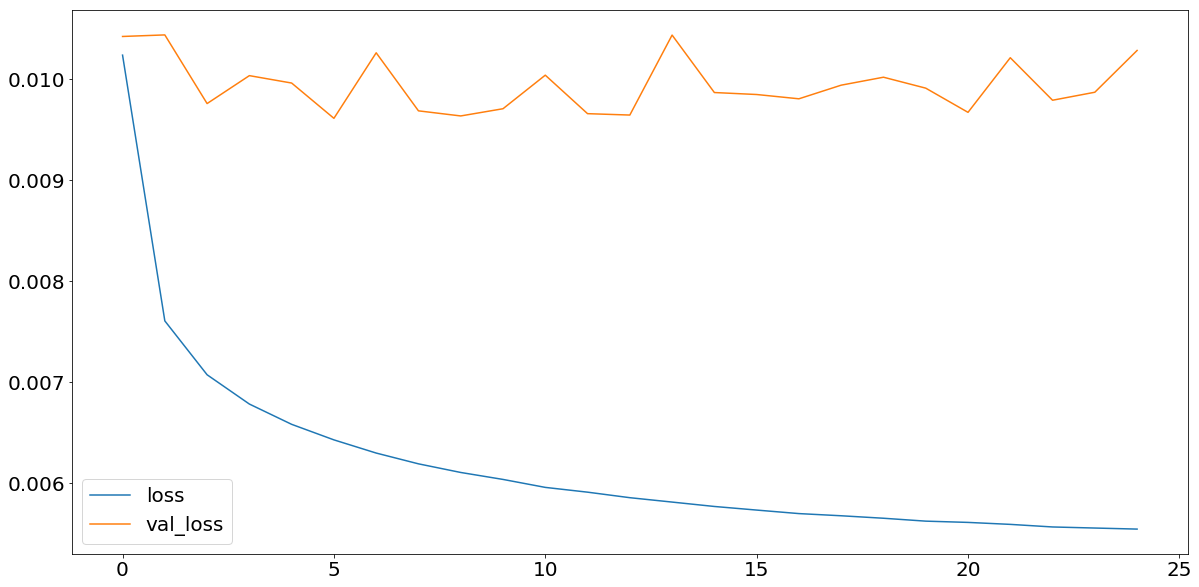

In [138]:
plt.rcParams['font.size'] = 20

pd.DataFrame(hist.history).plot(
    figsize=(20, 10)
)